In [1]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import healpy as hp

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.utils import train_model_2steps_temp, init_device
from modules.data import WeatherBenchDatasetXarrayHealpixTemp
from modules.healpix_models import UNetSphericalTempHealpix, UNetSphericalHealpix
from modules.test import create_iterative_predictions_healpix
from modules.test import compute_rmse_healpix
from modules.plotting import plot_rmses

datadir = "../data/healpix/"
input_dir = datadir + "5.625deg/"
model_save_path = datadir + "models/"
pred_save_path = datadir + "predictions/"

train_years = ('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 12*16*16
max_lead_time = 5*24
nb_timesteps = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,2"
gpu = [0, 1]
num_workers = 10
pin_memory = True

nb_epochs = 20
learning_rate = 8e-3

obs = xr.open_mfdataset(pred_save_path + 'observations.nc', combine='by_coords')
rmses_weyn = xr.open_dataset(datadir + 'metrics/rmses_weyn.nc')

In [2]:
from modules.data import WeatherBenchDatasetIterative

'''def train_model_2steps_temp(model, device, train_generator, epochs, lr, validation_data, model_filename):    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-7, weight_decay=0, amsgrad=False)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()  
        for batch_idx, (batch, labels) in enumerate(train_generator):
            # Transfer to GPU
            batch1 = batch[0].to(device)
            constants1 = batch[1].to(device)

            label1 = labels[0].to(device)
            label2 = labels[1].to(device)

            batch_size = batch1.shape[0]

            # Model
            output1 = model(batch1)
            batch2 = torch.cat((batch1[:, :, 1:, :], torch.cat((output1, constants1), dim=2).unsqueeze(2)), 
            dim=2)
            output2 = model(batch2)
            
            loss = criterion(output1, label1) + criterion(output2, label2)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
        train_loss = train_loss / (len(train_generator.dataset))
        train_losses.append(train_loss)
        
        model.eval()
        with torch.set_grad_enabled(False):
            index = 0
            
            for batch, labels in validation_data:
                # Transfer to GPU
                batch1 = batch[0].to(device)
                constants1 = batch[1].to(device)

                label1 = labels[0].to(device)
                label2 = labels[1].to(device)

                batch_size = batch1.shape[0]
                
                output1 = model(batch1)
                batch2 = torch.cat((batch1[:, :, 1:, :], torch.cat((output1, constants1), dim=2).unsqueeze(2)), 
                dim=2)
                output2 = model(batch2)
                
                val_loss = val_loss + (criterion(output1, label1).item() 
                                       + criterion(output2, label2).item()) * batch_size
                index = index + batch_size
                
        val_loss = val_loss / (len(validation_data.dataset))
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=epochs, l=train_loss, v_l=val_loss, t=time2-time1))
        
        torch.save(spherical_unet.state_dict(), model_filename[:-3] + '_epoch' + str(epoch) + '.h5')
        
    return train_losses, val_losses'''

class WeatherBenchDatasetXarrayHealpixTemp(Dataset):
    
    """ Dataset used for graph models (1D), where data is loaded from stored numpy arrays.
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset containing the input data
    out_features : int
        Number of output features
    delta_t : int
        Temporal spacing between samples in temporal sequence (in hours)
    len_sqce : int
        Length of the input and output (predicted) sequences
    years : tuple(str)
        Years used to split the data
    nodes : float
        Number of nodes each sample has
    max_lead_time : int
        Maximum lead time (in case of iterative predictions) in hours
    load : bool
        If true, load dataset to RAM
    mean : np.ndarray of shape 2
        Mean to use for data normalization. If None, mean is computed from data
    std : np.ndarray of shape 2
        std to use for data normalization. If None, mean is computed from data
    """
        
    def __init__(self, ds, out_features, delta_t, len_sqce, years, nodes, nb_timesteps, 
                 max_lead_time=None, load=True, mean=None, std=None):
        
        
        self.delta_t = delta_t
        self.len_sqce = len_sqce
        self.years = years
        
        self.nodes = nodes
        self.out_features = out_features
        self.max_lead_time = max_lead_time
        self.nb_timesteps = nb_timesteps
        
        self.data = ds.to_array(dim='level', name='Dataset').transpose('time', 'node', 'level')
        self.in_features = self.data.shape[-1]
        
        self.mean = self.data.mean(('time', 'node')).compute() if mean is None else mean
        self.std = self.data.std(('time', 'node')).compute() if std is None else std
        
        # Normalize
        self.data = (self.data - self.mean) / self.std
        
        # Count total number of samples
        total_samples = self.data.shape[0]        
        if max_lead_time is None:
            self.n_samples = total_samples - (len_sqce+1) * delta_t
        else:
            self.n_samples = total_samples - (len_sqce+1) * delta_t - max_lead_time
            
        
        # Create indexes
        self.idxs = [[[[sample_idx + delta_t*k for k in range(len_sqce)], sample_idx + delta_t * len_sqce], 
                      [sample_idx + delta_t * len_sqce, sample_idx + delta_t * (len_sqce+1)]] 
                     for sample_idx in range(self.n_samples)]
        
        if load: 
            print('Loading data into RAM')
            self.data.load()
            
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """ Returns sample and label corresponding to an index as torch.Tensor objects
            The return tensor shapes are (for the sample and the label): [n_vertex, len_sqce, n_features]
        """
        
        X = (torch.tensor(self.data.isel(time=self.idxs[idx][0][0]).values).float(). \
             permute(1, 0, 2).reshape(self.nodes, self.in_features*self.len_sqce), 
             torch.tensor(self.data.isel(time=self.idxs[idx][0][1]).values[:, self.out_features:]).float())
        
        y = (torch.Tensor(self.data.isel(time=self.idxs[idx][1][0]).values[:, :self.out_features]).float(), 
             torch.Tensor(self.data.isel(time=self.idxs[idx][1][1]).values[:, :self.out_features]).float())
        
        return X, y 
    
    
def train_model_2steps_temp(model, device, train_generator, epochs, lr, validation_data, model_filename):    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-7, weight_decay=0, amsgrad=False)
    
    in_features = train_generator.dataset.in_features
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()  
        for batch_idx, (batch, labels) in enumerate(train_generator):
            # Transfer to GPU
            batch1 = batch[0].to(device)
            constants1 = batch[1].to(device)

            label1 = labels[0].to(device)
            label2 = labels[1].to(device)

            batch_size = batch1.shape[0]

            # Model
            output1 = model(batch1)
            batch2 = torch.cat((batch1[:, :, in_features:], torch.cat((output1, constants1), dim=2)), dim=2)
            output2 = model(batch2)
            
            loss = criterion(output1, label1) + criterion(output2, label2)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
        train_loss = train_loss / (len(train_generator.dataset))
        train_losses.append(train_loss)
        
        model.eval()
        with torch.set_grad_enabled(False):
            index = 0
            
            for batch, labels in validation_data:
                # Transfer to GPU
                batch1 = batch[0].to(device)
                constants1 = batch[1].to(device)

                label1 = labels[0].to(device)
                label2 = labels[1].to(device)

                batch_size = batch1.shape[0]
                
                output1 = model(batch1)
                batch2 = torch.cat((batch1[:, :, in_features:], torch.cat((output1, constants1), 
                                                                          dim=2)), dim=2)
                output2 = model(batch2)
                
                val_loss = val_loss + (criterion(output1, label1).item() 
                                       + criterion(output2, label2).item()) * batch_size
                index = index + batch_size
                
        val_loss = val_loss / (len(validation_data.dataset))
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=epochs, l=train_loss, v_l=val_loss, t=time2-time1))
        
        torch.save(spherical_unet.state_dict(), model_filename[:-3] + '_epoch' + str(15+epoch) + '.h5')
        
    return train_losses, val_losses



def create_iterative_predictions_healpix_temp(model, device, dg):
    
    out_feat = dg.dataset.out_features
    
    train_std =  dg.dataset.std.values[:out_feat]
    train_mean = dg.dataset.mean.values[:out_feat]
    
    delta_t = dg.dataset.delta_t
    len_sqce = dg.dataset.len_sqce
    max_lead_time = dg.dataset.max_lead_time
    initial_lead_time = delta_t * len_sqce
    nodes = dg.dataset.nodes
    nside = int(np.sqrt(nodes/12))
    n_samples = dg.dataset.n_samples
    in_feat = dg.dataset.in_features
    
    # Lead times
    lead_times = np.arange(delta_t, max_lead_time + delta_t, delta_t)
    
    # Lat lon coordinates
    out_lon, out_lat = hp.pix2ang(nside, np.arange(nodes), lonlat=True)
    
    # Actual times
    start = np.datetime64(dg.dataset.years[0], 'h') + np.timedelta64(initial_lead_time, 'h')
    stop = start + np.timedelta64(dg.dataset.n_samples, 'h')
    times = np.arange(start, stop)
    
    # Variables
    var_dict_out = {var: None for var in ['z', 't']}
    
    # Constants
    constants = np.array(dg.dataset.data.isel(level=slice(out_feat, None)).values)
    
    dataloader = dg
    predictions = []
    model.eval()
    for lead in lead_times:
        outputs = []
        next_batch_ = []
        states = np.empty((n_samples, nodes, in_feat*len_sqce))
        
        time1 = time.time()

        for i, (sample, _) in enumerate(dataloader):
            inputs = sample[0].to(device)
            output = model(inputs)
            
            next_batch_.append(inputs[:, :, in_feat:].detach().cpu().clone().numpy())
            outputs.append(output.detach().cpu().clone().numpy()[:, :, :out_feat])
            
            
        next_batch = np.concatenate(next_batch_)    
        preds = np.concatenate(outputs)
        states[:, :, :(len_sqce-1)*in_feat] = next_batch
        states[:, :, (len_sqce-1)*in_feat:(len_sqce-1)*in_feat + out_feat] = preds
        states[:, :, -(in_features - out_features):] =  constants[(len_sqce-1)*delta_t+
                                                                  lead:n_samples+(len_sqce-1)*delta_t+lead, :]

        predictions.append(preds * train_std + train_mean)

        new_set = WeatherBenchDatasetIterative(states)
        dataloader = DataLoader(new_set, batch_size=batch_size, shuffle=False, num_workers=10)
        
        time2 = time.time()
        
    predictions = np.array(predictions)
    
    das = [];
    lev_idx = 0
    for var in ['z', 't']:       
        das.append(xr.DataArray(
            predictions[:, :, :, lev_idx],
            dims=['lead_time', 'time', 'node'],
            coords={'lead_time': lead_times, 'time': times, 'node': np.arange(nodes)},
            name=var
        ))
        lev_idx += 1
            
    prediction_ds = xr.merge(das)
    prediction_ds = prediction_ds.assign_coords({'lat': out_lat, 'lon': out_lon})
    return prediction_ds

In [3]:
z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords').rename({'z':'z500'})
t850 = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords').rename({'t':'t850'})
z1000 = xr.open_dataset(f'{input_dir}geopotential/geopotential_5.625deg.nc').sel(level=
                                                                                 1000).rename({'z':'z1000'})
rad = xr.open_mfdataset(f'{input_dir}toa_incident_solar_radiation/*.nc', combine='by_coords')

z500 = z500.isel(time=slice(7, None))
t850 = t850.isel(time=slice(7, None))
z1000 = z1000.isel(time=slice(7, None))

constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg.nc').rename({'orography' :'orog'})
constants = constants.assign(cos_lon=lambda x: np.cos(np.deg2rad(x.lon)))
constants = constants.assign(sin_lon=lambda x: np.sin(np.deg2rad(x.lon)))

temp = xr.DataArray(np.zeros(z500.dims['time']), coords=[('time', z500.time.values)])
constants, _ = xr.broadcast(constants, temp)

orog = constants['orog']
lsm = constants['lsm']
lats = constants['lat2d']
slt = constants['slt']
cos_lon = constants['cos_lon']
sin_lon = constants['sin_lon']

predictors_mean = xr.open_dataarray(datadir + 'predictors_mean.nc')
predictors_std = xr.open_dataarray(datadir + 'predictors_std.nc')
z1000_mean = xr.open_dataarray(datadir + 'z1000_mean.nc')
z1000_std = xr.open_dataarray(datadir + 'z1000_std.nc')
const_mean = xr.open_dataarray(input_dir + 'constants/const_mean.nc')
const_std = xr.open_dataarray(input_dir + 'constants/const_std.nc')

train_mean = xr.concat((predictors_mean, z1000_mean, const_mean), dim='level')
train_std = xr.concat((predictors_std, z1000_std, const_std), dim='level')

# z500, t850, orog, lats, lsm, slt, rad
in_features = 8
out_features = 3
ds = xr.merge([z500, t850, z1000, orog, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

In [4]:
len_sqce = 2
delta_t = 6


description = "all_const_len{}_delta{}".format(len_sqce, delta_t)

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_10days" + description + ".nc"

max_lead_time = 10*24


feature_idx = [0, 1, 3, 4, 5, 6, 7]
in_features = len(feature_idx)
out_features = 2
ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]


spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)
spherical_unet.load_state_dict(torch.load(model_filename), strict=False)

testing_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_test, out_features=out_features,
                                                  len_sqce=len_sqce, delta_t=delta_t, years=test_years, 
                                                  nodes=nodes, nb_timesteps=nb_timesteps, 
                                                  mean=train_mean, std=train_std, 
                                                  max_lead_time=max_lead_time)
batch_size=70
dataloader_test = DataLoader(testing_ds, batch_size=int(0.7*batch_size), shuffle=False,
                             num_workers=num_workers)

preds = create_iterative_predictions_healpix_temp(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

Loading data into RAM


# Length of sequence: 2

In [4]:
batch_size = 70

In [ ]:
len_sqce = 2
delta_t = 6

description = "all_const_z1000_len{}_delta{}".format(len_sqce, delta_t)

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features,
                                                   len_sqce=len_sqce, delta_t=delta_t, years=train_years,
                                                   nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean, std=train_std)
validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, 
                                                     len_sqce=len_sqce, delta_t=delta_t, years=val_years, 
                                                     nodes=nodes, nb_timesteps=nb_timesteps, 
                                                     mean=train_mean, std=train_std)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)


# Train model
train_loss, val_loss = train_model_2steps_temp(spherical_unet, device, dl_train, epochs=nb_epochs, 
                                               lr=learning_rate, validation_data=dl_val, 
                                               model_filename=model_filename)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()
'''
# Load optimal model
del spherical_unet
torch.cuda.empty_cache()

optimal_filename = model_filename#[:-3] + '_epoch' + str(np.argmin(val_loss)) + '.h5'

spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)
spherical_unet.load_state_dict(torch.load(optimal_filename), strict=False)'''

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_test, out_features=out_features,
                                                  len_sqce=len_sqce, delta_t=delta_t, years=test_years, 
                                                  nodes=nodes, nb_timesteps=nb_timesteps, 
                                                  mean=train_mean, std=train_std, 
                                                  max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=int(0.7*batch_size), shuffle=False,
                             num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix_temp(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time=6)

del spherical_unet, preds, rmse
torch.cuda.empty_cache()

Z500 - 0: 76.9087929165578
T850 - 0: 0.7635726581330314


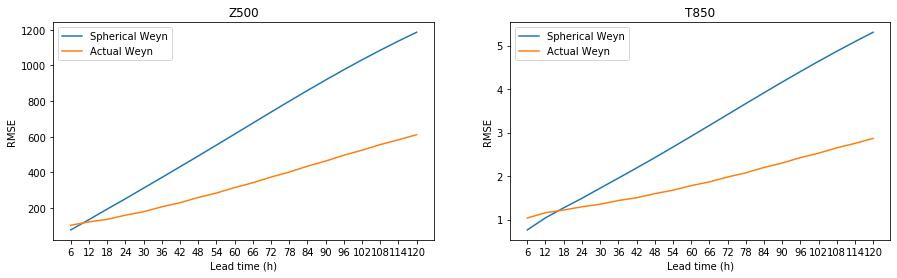

In [9]:
# Compute predictions
preds = create_iterative_predictions_healpix_temp(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time=6)

Loading data into RAM
Loading data into RAM
Epoch:   1/ 20  - loss: 0.109  - val_loss: 0.07488  - time: 1742.675523
Epoch:   2/ 20  - loss: 0.061  - val_loss: 0.06903  - time: 1764.417533
Epoch:   3/ 20  - loss: 0.054  - val_loss: 0.06787  - time: 1759.551396
Epoch:   4/ 20  - loss: 0.051  - val_loss: 0.06718  - time: 1762.941111
Epoch:   5/ 20  - loss: 0.049  - val_loss: 0.06087  - time: 1762.259767
Epoch:   6/ 20  - loss: 0.047  - val_loss: 0.06011  - time: 1764.387260
Epoch:   7/ 20  - loss: 0.046  - val_loss: 0.06761  - time: 1765.929639
Epoch:   8/ 20  - loss: 0.045  - val_loss: 0.06158  - time: 1763.395760
Epoch:   9/ 20  - loss: 0.044  - val_loss: 0.05667  - time: 1765.516890
Epoch:  10/ 20  - loss: 0.044  - val_loss: 0.06011  - time: 1762.467128
Epoch:  11/ 20  - loss: 0.043  - val_loss: 0.05784  - time: 1765.762122
Epoch:  12/ 20  - loss: 0.043  - val_loss: 0.05482  - time: 1764.484922
Epoch:  13/ 20  - loss: 0.042  - val_loss: 0.05664  - time: 1763.333671
Epoch:  14/ 20  - lo

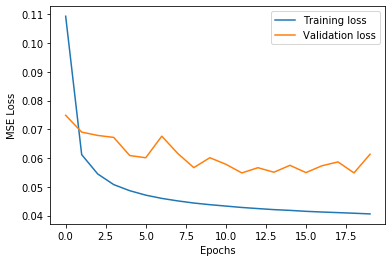

Loading data into RAM
Z500 - 0: 243.9538757452764
T850 - 0: 1.4331271594081583


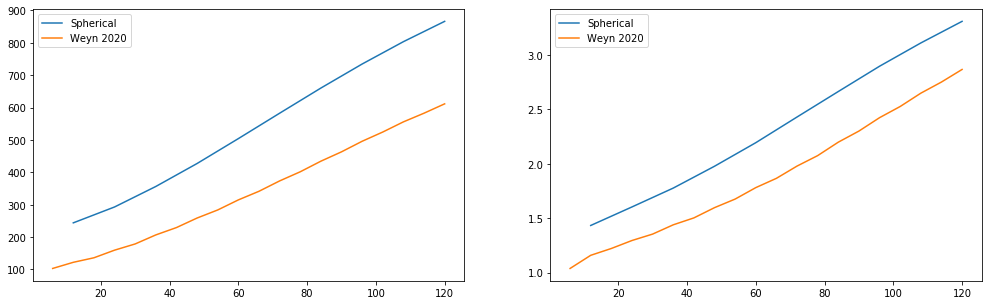

In [5]:
len_sqce = 2
delta_t = 12

batch_size = 70

description = "all_const_z1000_len{}_delta{}".format(len_sqce, delta_t)

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features,
                                                   len_sqce=len_sqce, delta_t=delta_t, years=train_years,
                                                   nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean, std=train_std)
validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, 
                                                     len_sqce=len_sqce, delta_t=delta_t, years=val_years, 
                                                     nodes=nodes, nb_timesteps=nb_timesteps, 
                                                     mean=train_mean, std=train_std)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)


# Train model
train_loss, val_loss = train_model_2steps_temp(spherical_unet, device, dl_train, epochs=nb_epochs, 
                                               lr=learning_rate, validation_data=dl_val, 
                                               model_filename=model_filename)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()
'''# Load optimal model
del spherical_unet
torch.cuda.empty_cache()

optimal_filename = model_filename[:-3] + '_epoch' + str(np.argmin(val_loss)) + '.h5'

spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)
spherical_unet.load_state_dict(torch.load(optimal_filename), strict=False)'''


# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_test, out_features=out_features,
                                                  len_sqce=len_sqce, delta_t=delta_t, years=test_years, 
                                                  nodes=nodes, nb_timesteps=nb_timesteps, 
                                                  mean=train_mean, std=train_std, 
                                                  max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=int(0.7*batch_size), shuffle=False,
                             num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix_temp(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])

f, axs = plt.subplots(1, 2, figsize=(17, 5))

lead_times_ = np.arange(delta_t, max_lead_time + delta_t, delta_t)
lead_times = np.arange(6, max_lead_time + 6, 6)

axs[0].plot(lead_times_, rmse.z.values, label='Spherical')
axs[0].plot(lead_times, rmses_weyn.z.values, label='Weyn 2020')
axs[0].legend()

axs[1].plot(lead_times_, rmse.t.values, label='Spherical')
axs[1].plot(lead_times, rmses_weyn.t.values, label='Weyn 2020')
axs[1].legend()

plt.show()

del spherical_unet, preds, rmse
torch.cuda.empty_cache()

# Length of sequence: 4

In [6]:
batch_size = 100

Loading data into RAM
Loading data into RAM
Epoch:   1/ 20  - loss: 0.059  - val_loss: 0.06492  - time: 1870.344388
Epoch:   2/ 20  - loss: 0.028  - val_loss: 0.03982  - time: 1871.519011
Epoch:   3/ 20  - loss: 0.025  - val_loss: 0.03090  - time: 1870.103357
Epoch:   4/ 20  - loss: 0.023  - val_loss: 0.02610  - time: 1869.596218
Epoch:   5/ 20  - loss: 0.022  - val_loss: 0.03156  - time: 1868.884856
Epoch:   6/ 20  - loss: 0.021  - val_loss: 0.02291  - time: 1948.184222
Epoch:   7/ 20  - loss: 0.021  - val_loss: 0.02416  - time: 1879.699107
Epoch:   8/ 20  - loss: 0.020  - val_loss: 0.02755  - time: 1844.207501
Epoch:   9/ 20  - loss: 0.020  - val_loss: 0.02400  - time: 1874.336668
Epoch:  10/ 20  - loss: 0.020  - val_loss: 0.02845  - time: 1873.913994
Epoch:  11/ 20  - loss: 0.019  - val_loss: 0.02154  - time: 1877.015433
Epoch:  12/ 20  - loss: 0.019  - val_loss: 0.02056  - time: 1877.222861
Epoch:  13/ 20  - loss: 0.019  - val_loss: 0.02218  - time: 1874.125396
Epoch:  14/ 20  - lo

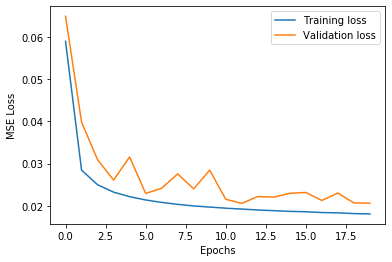

Loading data into RAM
Z500 - 0: 73.11827149029975
T850 - 0: 0.7319241828024141


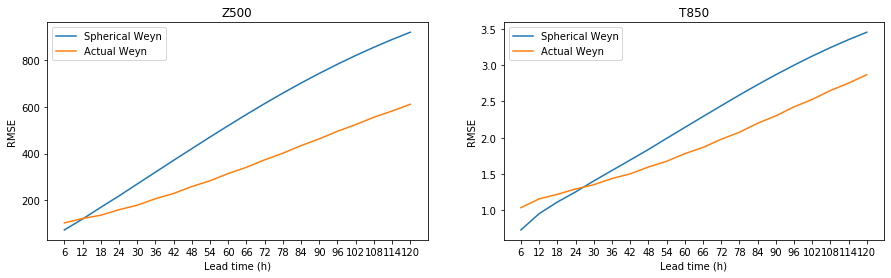

In [7]:
len_sqce = 4
delta_t = 6

description = "all_const_z1000_len{}_delta{}".format(len_sqce, delta_t)

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features,
                                                   len_sqce=len_sqce, delta_t=delta_t, years=train_years,
                                                   nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean, std=train_std)
validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, 
                                                     len_sqce=len_sqce, delta_t=delta_t, years=val_years, 
                                                     nodes=nodes, nb_timesteps=nb_timesteps, 
                                                     mean=train_mean, std=train_std)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)


# Train model
train_loss, val_loss = train_model_2steps_temp(spherical_unet, device, dl_train, epochs=nb_epochs, 
                                               lr=learning_rate, validation_data=dl_val, 
                                               model_filename=model_filename)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()
'''# Load optimal model
del spherical_unet
torch.cuda.empty_cache()

optimal_filename = model_filename[:-3] + '_epoch' + str(np.argmin(val_loss)) + '.h5'

spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)
spherical_unet.load_state_dict(torch.load(optimal_filename), strict=False)'''


# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_test, out_features=out_features,
                                                  len_sqce=len_sqce, delta_t=delta_t, years=test_years, 
                                                  nodes=nodes, nb_timesteps=nb_timesteps, 
                                                  mean=train_mean, std=train_std, 
                                                  max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=int(0.3*batch_size), shuffle=False,
                             num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix_temp(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time=6)

del spherical_unet, preds, rmse
torch.cuda.empty_cache()

Loading data into RAM
Loading data into RAM
Epoch:   1/ 20  - loss: 0.129  - val_loss: 0.09034  - time: 1855.595276
Epoch:   2/ 20  - loss: 0.064  - val_loss: 0.07248  - time: 1856.446625
Epoch:   3/ 20  - loss: 0.056  - val_loss: 0.06647  - time: 1854.087487
Epoch:   4/ 20  - loss: 0.052  - val_loss: 0.06649  - time: 1854.378580
Epoch:   5/ 20  - loss: 0.049  - val_loss: 0.05765  - time: 1853.870775
Epoch:   6/ 20  - loss: 0.047  - val_loss: 0.05957  - time: 1855.225228
Epoch:   7/ 20  - loss: 0.046  - val_loss: 0.05875  - time: 1842.814106
Epoch:   8/ 20  - loss: 0.045  - val_loss: 0.05620  - time: 1842.784569
Epoch:   9/ 20  - loss: 0.044  - val_loss: 0.05718  - time: 1860.227736
Epoch:  10/ 20  - loss: 0.043  - val_loss: 0.05515  - time: 1862.099493
Epoch:  11/ 20  - loss: 0.043  - val_loss: 0.05556  - time: 1864.546319
Epoch:  12/ 20  - loss: 0.042  - val_loss: 0.05499  - time: 1869.212194
Epoch:  13/ 20  - loss: 0.042  - val_loss: 0.05418  - time: 1861.810884
Epoch:  14/ 20  - lo

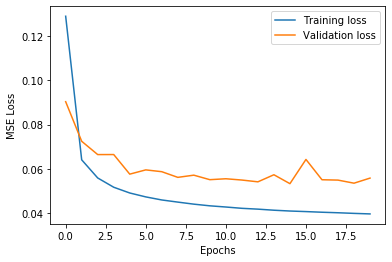

Loading data into RAM
Z500 - 0: 245.45156375736036
T850 - 0: 1.4500744459275454


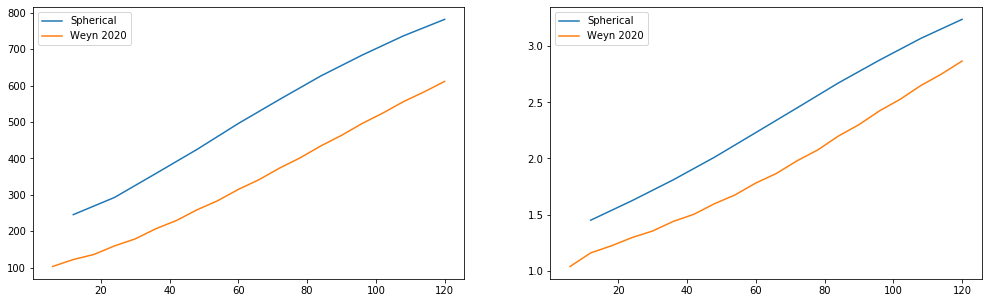

In [8]:
len_sqce = 4
delta_t = 12

description = "all_const_z1000_len{}_delta{}".format(len_sqce, delta_t)

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features,
                                                   len_sqce=len_sqce, delta_t=delta_t, years=train_years,
                                                   nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean, std=train_std)
validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, 
                                                     len_sqce=len_sqce, delta_t=delta_t, years=val_years, 
                                                     nodes=nodes, nb_timesteps=nb_timesteps, 
                                                     mean=train_mean, std=train_std)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)


# Train model
train_loss, val_loss = train_model_2steps_temp(spherical_unet, device, dl_train, epochs=nb_epochs, 
                                               lr=learning_rate, validation_data=dl_val, 
                                               model_filename=model_filename)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()
'''# Load optimal model
del spherical_unet
torch.cuda.empty_cache()

optimal_filename = model_filename[:-3] + '_epoch' + str(np.argmin(val_loss)) + '.h5'

spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features*len_sqce, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)
spherical_unet.load_state_dict(torch.load(optimal_filename), strict=False)'''


# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_test, out_features=out_features,
                                                  len_sqce=len_sqce, delta_t=delta_t, years=test_years, 
                                                  nodes=nodes, nb_timesteps=nb_timesteps, 
                                                  mean=train_mean, std=train_std, 
                                                  max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=int(0.7*batch_size), shuffle=False,
                             num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix_temp(spherical_unet, device, dataloader_test)
preds.to_netcdf(pred_filename)

# Compute and save RMSE
rmse = compute_rmse_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])

f, axs = plt.subplots(1, 2, figsize=(17, 5))

lead_times_ = np.arange(delta_t, max_lead_time + delta_t, delta_t)
lead_times = np.arange(6, max_lead_time + 6, 6)

axs[0].plot(lead_times_, rmse.z.values, label='Spherical')
axs[0].plot(lead_times, rmses_weyn.z.values, label='Weyn 2020')
axs[0].legend()

axs[1].plot(lead_times_, rmse.t.values, label='Spherical')
axs[1].plot(lead_times, rmses_weyn.t.values, label='Weyn 2020')
axs[1].legend()

plt.show()

del spherical_unet, preds, rmse
torch.cuda.empty_cache()

# Comparison

In [3]:
filename = datadir+'metrics/rmse_all_const_z1000_len{}_delta{}'

rmse_2_6 = xr.open_dataset(filename.format(2, 6) + '.nc')
rmse_2_12 = xr.open_dataset(filename.format(2, 12) + '.nc')

rmse_4_6 = xr.open_dataset(filename.format(4, 6) + '.nc')
rmse_4_12 = xr.open_dataset(filename.format(4, 12) + '.nc')
rmse_1 = xr.open_dataset(datadir+'metrics/rmse_all_const.nc')

lead_times_ = np.arange(12, max_lead_time + 12, 12)
lead_times = np.arange(6, max_lead_time + 6, 6)

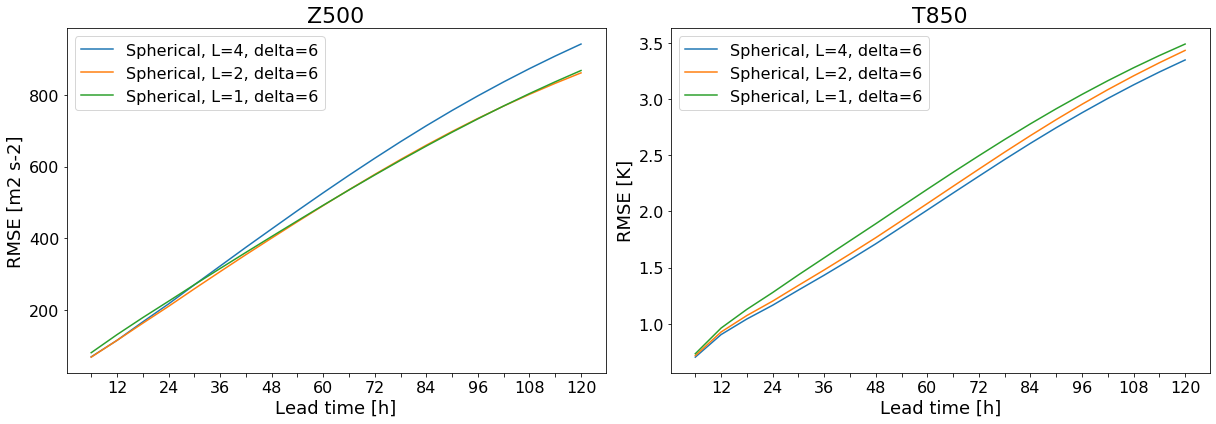

In [12]:
f, axs = plt.subplots(1, 2, figsize=(17, 6))

xlabels = [str(t) if t%4 == 0 else '' for t in lead_times]

axs[0].plot(lead_times, rmse_1.z.values, label='$L=1$, $\Delta_t = 6$')
axs[0].plot(lead_times, rmse_2_6.z.values, label='$L=2$, $\Delta_t = 6$')
axs[0].plot(lead_times, rmse_4_6.z.values, label='$L=4$, $\Delta_t = 6$')
axs[0].legend()

axs[1].plot(lead_times, rmse_1.t.values, label='$L=1$, $\Delta_t = 6$')
axs[1].plot(lead_times, rmse_2_6.t.values, label='$L=2$, $\Delta_t = 6$')
axs[1].plot(lead_times, rmse_4_6.t.values, label='$L=4$, $\Delta_t = 6$')
axs[1].legend()


axs[0].set_xticks(lead_times)
axs[1].set_xticks(lead_times)
axs[0].set_xticklabels(xlabels)
axs[1].set_xticklabels(xlabels)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[0].set_xlabel('Lead time [h]', fontsize='18')
axs[1].set_xlabel('Lead time [h]', fontsize='18')
axs[0].set_ylabel('RMSE [$m^2 s^{-2}$]', fontsize='18')
axs[1].set_ylabel('RMSE [K]', fontsize='18')
axs[0].set_title('Z500', fontsize='22')
axs[1].set_title('T850', fontsize='22')
axs[0].legend(fontsize=16, loc='upper left')
axs[1].legend(fontsize=16)

plt.tight_layout()

plt.savefig('temporal_rmse_delta6.eps', format='eps', bbox_inches='tight')

plt.show()

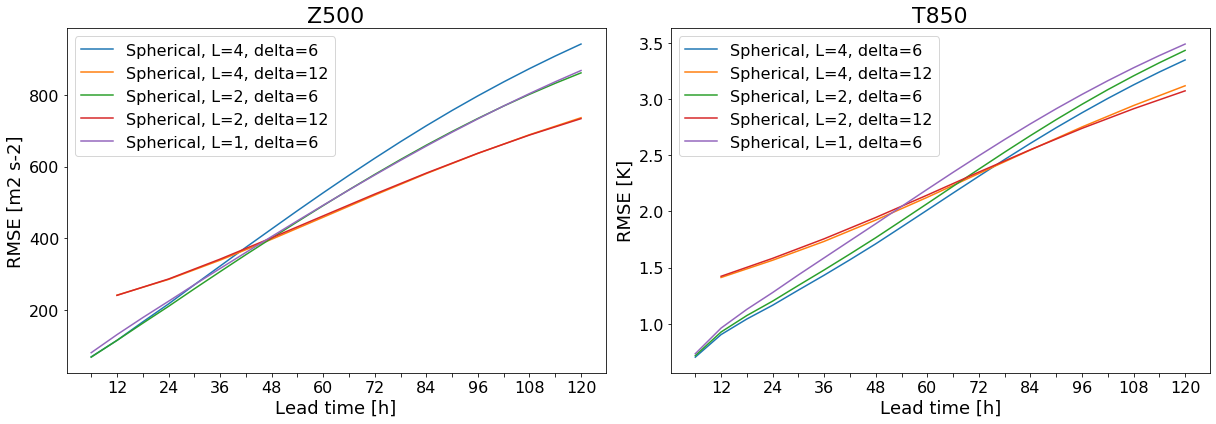

In [22]:
f, axs = plt.subplots(1, 2, figsize=(17, 6))

axs[0].plot(lead_times, rmse_2_6.z.values, label='$L=2$, $\Delta_t = 6$')
axs[0].plot(lead_times, rmse_4_6.z.values, label='$L=4$, $\Delta_t = 6$')
axs[0].plot(lead_times_, rmse_2_12.z.values, label='$L=2$, $\Delta_t = 12$')
axs[0].plot(lead_times_, rmse_4_12.z.values, label='$L=4$, $\Delta_t = 12$')
#axs[0].plot(lead_times, rmse_1.z.values, label='Spherical, L=1, delta=6')
#axs[0].plot(lead_times, rmses_weyn.z.values, label='Weyn 2020')

axs[1].plot(lead_times, rmse_2_6.t.values, label='$L=2$, $\Delta_t = 6$')
axs[1].plot(lead_times, rmse_4_6.t.values, label='$L=4$, $\Delta_t = 6$')
axs[1].plot(lead_times_, rmse_2_12.t.values, label='$L=2$, $\Delta_t = 12$')
axs[1].plot(lead_times_, rmse_4_12.t.values, label='$L=4$, $\Delta_t = 12$')
#axs[1].plot(lead_times, rmse_1.t.values, label='Spherical, L=1, delta=6')
#axs[1].plot(lead_times, rmses_weyn.t.values, label='Weyn 2020')

axs[0].set_xticks(lead_times)
axs[1].set_xticks(lead_times)
axs[0].set_xticklabels(xlabels)
axs[1].set_xticklabels(xlabels)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[0].set_xlabel('Lead time [h]', fontsize='18')
axs[1].set_xlabel('Lead time [h]', fontsize='18')
axs[0].set_ylabel('RMSE [$m^2 s^{-2}$]', fontsize='18')
axs[1].set_ylabel('RMSE [K]', fontsize='18')
axs[0].set_title('Z500', fontsize='22')
axs[1].set_title('T850', fontsize='22')
axs[0].legend(fontsize=16, loc='upper left')
axs[1].legend(fontsize=16)

plt.tight_layout()

plt.savefig('temporal_rmse_all.eps', format='eps', bbox_inches='tight')

plt.show()